# Use Tabular Q-learning  & Deep Q-Networks (DQN) to solve CliffWalking-v0 environment

In [12]:
### Tabular Q-learning 

Note: you may need to restart the kernel to use updated packages.


Training complete!
Q-Table:
[[ -13.14845992  -12.6252839   -12.66584633  -13.11121877]
 [ -12.42877823  -11.90635962  -11.92305261  -13.09374383]
 [ -11.69000634  -11.15100387  -11.17094728  -12.42043048]
 [ -10.79462959  -10.32246839  -10.33773439  -11.71707077]
 [ -10.05519815   -9.45888502   -9.46197239  -10.86036301]
 [  -9.27962378   -8.57052634   -8.57464449   -9.96388273]
 [  -8.39545929   -7.67122705   -7.67352303   -9.31479998]
 [  -7.45974073   -6.75613472   -6.75699559   -8.21690187]
 [  -6.56170209   -5.82812793   -5.83009602   -7.38211797]
 [  -5.6532268    -4.89057998   -4.8916004    -6.40806962]
 [  -4.7762165    -3.93794081   -3.93808691   -5.57613643]
 [  -3.86299102   -3.89052787   -2.96994549   -4.74877757]
 [ -13.37899805  -12.24355401  -12.24364077  -12.78843734]
 [ -12.65595792  -11.36056277  -11.36050777  -12.91189694]
 [ -11.92900091  -10.46586378  -10.46585072  -12.04416694]
 [ -11.13278677   -9.56166254   -9.56167288  -11.23113572]
 [ -10.25469808   -8.6482039

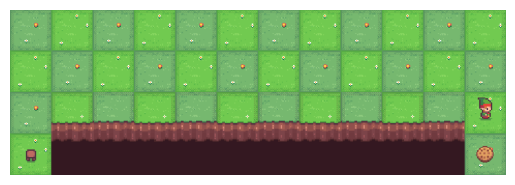

In [19]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

env = gym.make("CliffWalking-v0", render_mode="rgb_array")

# Parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.1  # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for exploration
episodes = 2000  # Number of episodes for training

# Initialize Q-table
q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Epsilon-greedy policy
def epsilon_greedy_policy(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(q_table[state])  # Exploit

# Training loop
for episode in range(episodes):
    state = env.reset(seed=42)[0]
    done = False
    while not done:
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action]
        td_error = td_target - q_table[state][action]
        q_table[state][action] += alpha * td_error
        state = next_state
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

print("Training complete!")
print("Q-Table:")
print(q_table)

# Function to render the policy
def render_policy():
    state = env.reset(seed=42)[0]
    frames = []
    done = False
    while not done:
        frames.append(env.render())
        action = np.argmax(q_table[state])
        state, reward, done, truncated, _ = env.step(action)
    return frames

# Function to display animation with controls
def plot_animation_with_controls(frames):
    fig, ax = plt.subplots()
    ax.axis("off")
    img = plt.imshow(frames[0])

    def update(frame):
        img.set_data(frame)
        return [img]

    ani = FuncAnimation(fig, update, frames=frames, interval=200, blit=True)
    return HTML(ani.to_jshtml())  

# Main script
if __name__ == "__main__":
    frames = render_policy()
    animation_html = plot_animation_with_controls(frames)
    display(animation_html)  

### Deep Q-Networks

In [91]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Environment setup
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
n_states = env.observation_space.n
n_actions = env.action_space.n
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
episodes = 50  
batch_size = 16  
memory_size = 500  

# One-hot encode discrete state
def one_hot_encode(state, n_states):
    encoded = np.zeros(n_states)
    encoded[state] = 1.0
    return encoded

# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size, input_dim):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((max_size, input_dim))
        self.new_state_memory = np.zeros((max_size, input_dim))
        self.action_memory = np.zeros(max_size, dtype=np.int32)
        self.reward_memory = np.zeros(max_size)
        self.terminal_memory = np.zeros(max_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]
        return states, actions, rewards, new_states, dones

# DQN Agent
class DQNAgent:
    def __init__(self, input_dim, n_actions):
        self.n_actions = n_actions
        self.memory = ReplayBuffer(memory_size, input_dim)
        self.q_eval = self.build_model(input_dim, n_actions)
        self.epsilon = epsilon

    def build_model(self, input_dim, n_actions):
        model = models.Sequential([
            layers.Dense(32, activation='relu', input_shape=(input_dim,)),
            layers.Dense(16, activation='relu'),
            layers.Dense(n_actions, activation='linear')  
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        q_values = self.q_eval.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values)

    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < batch_size:
            return
        states, actions, rewards, new_states, dones = self.memory.sample_buffer(batch_size)
        q_eval = self.q_eval.predict(states, verbose=0)
        q_next = self.q_eval.predict(new_states, verbose=0)
        q_target = q_eval.copy()
        batch_index = np.arange(batch_size, dtype=np.int32)
        q_target[batch_index, actions] = rewards + gamma * np.max(q_next, axis=1) * ~dones
        self.q_eval.train_on_batch(states, q_target)
        self.epsilon = max(epsilon_min, self.epsilon * epsilon_decay)

# Train the DQN agent
def train_dqn(agent, episodes):
    step_counter = 0
    train_frequency = 4  # Update the model every 4 steps
    for episode in range(episodes):
        state = one_hot_encode(env.reset(seed=42)[0], n_states)
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state_idx, reward, done, truncated, _ = env.step(action)
            next_state = one_hot_encode(next_state_idx, n_states)
            agent.store_transition(state, action, reward, next_state, done)

            # Perform learning step every `train_frequency` steps
            if step_counter % train_frequency == 0:
                agent.learn()
            step_counter += 1

            state = next_state
        print(f"Episode {episode + 1}/{episodes} completed")
    print("Training complete!")

# Render the policy
def render_policy(agent, n_max_steps=50):
    """Render the policy with a cap on maximum steps."""
    state = one_hot_encode(env.reset(seed=42)[0], n_states)
    frames = []
    done = False
    steps = 0
    while not done and steps < n_max_steps:
        action = agent.choose_action(state)
        state_idx, reward, done, truncated, _ = env.step(action)
        frames.append(env.render())  # Capture frame
        state = one_hot_encode(state_idx, n_states)
        steps += 1
    env.close()  
    print(f"Rendered {len(frames)} frames")
    return frames

# Animation with interactive controls
def plot_animation(frames):
    """Create an interactive animation with controls."""
    fig, ax = plt.subplots()
    ax.axis("off")  
    img = ax.imshow(frames[0]) 

    def update(frame):
        img.set_data(frame)  
        return [img]

    # Set interval for playback (200ms per frame)
    ani = FuncAnimation(fig, update, frames=frames, interval=200, blit=True)
    plt.close(fig) 
    return HTML(ani.to_jshtml())  

# Main script
if __name__ == "__main__":
    # Step 1: Initialize the agent
    agent = DQNAgent(n_states, n_actions)

    # Step 2: Train the agent 
    train_dqn(agent, episodes)

    # Step 3: Render the learned policy 
    frames = render_policy(agent, n_max_steps=50)  
    print(f"Number of frames rendered: {len(frames)}")

    # Step 4: Create and display the animation
    animation = plot_animation(frames)
    display(animation)  

Episode 1/50 completed
Episode 2/50 completed
Episode 3/50 completed
Episode 4/50 completed
Episode 5/50 completed
Episode 6/50 completed
Episode 7/50 completed
Episode 8/50 completed
Episode 9/50 completed
Episode 10/50 completed
Episode 11/50 completed
Episode 12/50 completed
Episode 13/50 completed
Episode 14/50 completed
Episode 15/50 completed
Episode 16/50 completed
Episode 17/50 completed
Episode 18/50 completed
Episode 19/50 completed
Episode 20/50 completed
Episode 21/50 completed
Episode 22/50 completed
Episode 23/50 completed
Episode 24/50 completed
Episode 25/50 completed
Episode 26/50 completed
Episode 27/50 completed
Episode 28/50 completed
Episode 29/50 completed
Episode 30/50 completed
Episode 31/50 completed
Episode 32/50 completed
Episode 33/50 completed
Episode 34/50 completed
Episode 35/50 completed
Episode 36/50 completed
Episode 37/50 completed
Episode 38/50 completed
Episode 39/50 completed
Episode 40/50 completed
Episode 41/50 completed
Episode 42/50 completed
E